# Week 5 - Boundary Value Problems in 2D
## Kiran Shila - U54532811

In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using BenchmarkTools

## Formulation
Alright, let's form some finite differences.

### Problem to Solve
$-\nabla^2\varphi(x,y) = s(x,y)$

Then to the differential equation for this coordinate system

$-\frac{\delta^2\varphi}{\delta x^2}-\frac{\delta^2\varphi}{\delta y^2} = s(x,y)$

### Finite Difference Formulation
We will use the central finite difference to formulate the A matrix

$-\frac{\varphi(x_{i-1},y_j) - 2\varphi(x_i,y_j) + \varphi(x_{i+1},y_j)}{\Delta x^2}-\frac{\varphi(x_{i},y_{j-1}) - 2\varphi(x_i,y_j) + \varphi(x_i,y_{j+1})}{\Delta y^2} = s(x_i,y_j)$

### Finite Difference as a Matrix
So as a matrix:

$\textbf{D}_x^{(2)} = \frac{1}{\Delta_x^2}
\begin{bmatrix}
    -2 & 1 & 0 & \dots  & 0 \\
    1 & -2 & 1 & \dots  & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \dots  & -2
\end{bmatrix}
$

But, we need to correct some terms as we are in 2D.

If we assume the problem space is L x H (columns,rows) , we can form the source vector as so

$
\begin{bmatrix}
    f_1 & f_{H+1} & f_{2H+1} & \dots  & f_{HL-L+1} \\
    f_2 & f_{H+2} & f_{2H+2} & \dots  & f_{HL-L+2} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    f_H &  f_{2H} & f_{3H} & \dots  & f_{HL}
\end{bmatrix} => 
f = 
\begin{bmatrix}
f_1 \\
f_2 \\
\vdots \\
f_{HL}
\end{bmatrix}
$

This is then consistent with how reshape works in julia (and in MATLAB)

In [2]:
A = [1 2 3;4 5 6;7 8 9]

3×3 Array{Int64,2}:
 1  2  3
 4  5  6
 7  8  9

In [3]:
A_Vec = reshape(A,(1,9))

1×9 Array{Int64,2}:
 1  4  7  2  5  8  3  6  9

This is nice because when we solve for $f$, we can `reshape` to get back to the proper 2D matrix again

In [4]:
reshape(A_Vec,(3,3))

3×3 Array{Int64,2}:
 1  2  3
 4  5  6
 7  8  9

So now, in the x derivative matrix, $\textbf{D}_x^{(2)}$, we will have entries that are indicitive of the boundary condition. When we want the x partial derivative at the point on the left edge, we need to make an assumption about the point to the left and vice versa for the right edge. Due to the way we formed $f$, that means the point in $\textbf{D}_x^{(2)}$ at $(L,L+1)$ and $(L+1,L)$ control the boundary conditions. **However**, if we but a value in that location, that would get multiplied by the next term in $f$, which is not the desired outcome. Therefore, we have to but 0 there to *disconnect* those rows in 2D and apply the boundary conditions to b.

Formulating $\textbf{D}_y^{(2)}$ is very similar, where we have to account for where y connects in $f$. Because the next Y term is $L$ away from $f_k$, we have to place the 1s for the $y_{j-1}$ entry at the $\pm H$ diagonals.

Finally, as before, our problem statement is $-\frac{\varphi(x_{i-1},y_j) - 2\varphi(x_i,y_j) + \varphi(x_{i+1},y_j)}{\Delta x^2}-\frac{\varphi(x_{i},y_{j-1}) - 2\varphi(x_i,y_j) + \varphi(x_i,y_{j+1})}{\Delta y^2} = s(x_i,y_j)$

We can rewrite this as matricies with $-\frac{1}{\Delta_x^2}\textbf{D}_x^{(2)}f-\frac{1}{\Delta_y^2}\textbf{D}_y^{(2)}f = s(x,y)$, simplifying the equation: $f(-\frac{1}{\Delta_x^2}\textbf{D}_x^{(2)}-\frac{1}{\Delta_y^2}\textbf{D}_y^{(2)}) = s(x,y)$

The subtraction turns the $\textbf{D}$ matricies into an $\textbf{A}$ matrix, and our problem is $\textbf{A}x = b$

In [69]:
# I'd rather pass in numpoints as a tuple so I can support non-square problem spaces
function poisson_2d_dirichlet(source::Function,dirichlet::Function,
                              L::Number,H::Number,numPoints::Tuple{Integer,Integer})
    # numPoints[1] is the "L" from my formulation
    Δx = L/numPoints[1] # Physical resolutions
    Δy = H/numPoints[2]
    
    # We are only solving the inner matrix, the outer edge is defined with the boundary condition
    problemSpace = (numPoints[1]-2)*(numPoints[2]-2)
    
    # Form the diagonals
    mainDiagonal = 0 => fill(-2,problemSpace)
    topDiagonal =  1 => fill(1,problemSpace-1)
    botDiagonal = -1 => fill(1,problemSpace-1)
    D_x = spdiagm(mainDiagonal,topDiagonal,botDiagonal)
    # Now place the zeros in the off-diagonals
    for i = numPoints[1]-2:numPoints[1]-2:problemSpace-1
        D_x[i,i+1] = 0
        D_x[i+1,i] = 0
    end
    # And fix the sparse matrix to clean the zeros
    dropzeros!(D_x)
    
    # Now to formulate D_y
    topDiagonal =  numPoints[1]-2 => fill(1,problemSpace-(numPoints[2]-2))
    botDiagonal = -(numPoints[1]-2) => fill(1,problemSpace-(numPoints[2]-2))
    D_y = spdiagm(mainDiagonal,topDiagonal,botDiagonal)
    
    # Now make A
    A = (-(1/Δx^2).*D_x -(1/Δy^2).*D_y)
    
    # Now generate the source vector in 2D
    s = [source(x,y,numPoints[1],numPoints[2]) for x = 1:numPoints[1], y = 1:numPoints[2]]
    
    # Grab the middle of b, as we know the boundary with the boundary condition
    b = s[2:end-1,2:end-1]
    
    # Apply the boundary conditions
    # There are 8 cases: All of the corners, and the rest of the edges
    
    # Top left and right
    b[1,1] = b[1,1] + dirichlet(2,1,numPoints[1],numPoints[2])/Δy^2 + 
                      dirichlet(1,2,numPoints[1],numPoints[2])/Δx^2
    b[1,end] = b[1,end] + dirichlet(size(b)[2]+1,1,numPoints[1],numPoints[2])/Δy^2 + 
                          dirichlet(size(b)[2]+2,2,numPoints[1],numPoints[2])/Δx^2
    
    # Bottom left and right
    b[end,1] = b[end,1] + dirichlet(2,size(b)[1]+2,numPoints[1],numPoints[2])/Δy^2 + 
                          dirichlet(1,size(b)[1]+1,numPoints[1],numPoints[2])/Δx^2
    b[end,end] = b[end,end] + dirichlet(size(b)[2]+2,size(b)[1]+1,numPoints[1],numPoints[2])/Δx^2 + 
                              dirichlet(size(b)[2]+1,size(b)[1]+2,numPoints[1],numPoints[2])/Δy^2
    
    # Top and Bottom Edge
    for j = 2:size(b)[2]-1
        b[1,j] = b[1,j] + dirichlet(j+1,1,numPoints[1],numPoints[2])/Δy^2
        b[end,j] = b[end,j] + dirichlet(j+1,size(b)[1]+2,numPoints[1],numPoints[2])/Δy^2
    end

    
    # Left and Right Edge
    for i = 2:size(b)[1]-1
        b[i,1] = b[i,1] + dirichlet(1,i+1,numPoints[1],numPoints[2])/Δx^2
        b[i,end] = b[i,end] + dirichlet(size(b)[2]+2,i+1,numPoints[1],numPoints[2])/Δx^2
    end
    
    # Source, modified with boundaries to return
    s_prime = [dirichlet(x,y,numPoints[1],numPoints[2]) for x = 1:numPoints[1], y=1:numPoints[2]]
    s_prime[2:end-1,2:end-1] = b
    
    # Reshape to 1D
    b = reshape(b,problemSpace)

    # Solutions, with added boundaries
    f = [dirichlet(x,y,numPoints[1],numPoints[2]) for x = 1:numPoints[1], y=1:numPoints[2]]
    f[2:end-1,2:end-1] = reshape(A\b,(numPoints[1]-2,numPoints[2]-2))
        
    # Solve
    return(f,s_prime)
end

poisson_2d_dirichlet (generic function with 1 method)

Now we write some functions that describe the source

In [6]:
# Zero Source
function zero_s(args...)
    return 0.
end

# Uniform Source
function uniform_s(args...)
    return 1.
end

# Linear Source
function linear_s(args...)
    return args[1]/args[3] # x/L
end

# Linear Source in x and y
function linear_xy_s(args...)
    return args[1]/args[3] + (2*args[2])/args[4]
end

# Non Linear
function nonlinear_s(args...)
    return (args[1]/args[3])^2 + sin(10*args[2]/args[4])
end

nonlinear_s (generic function with 1 method)

Now we will write some dirichlet conditions with signature x,y,L,H

In [51]:
function homogeneous(args...)
    return 0.
end

function non_homogeneous(args...)
    return 1.
end

function homogeneous_x(args...)
    if args[1] == 1 || args[1] == args[3]
        return 0.
    elseif args[2] == 1 || args[2] == args[4]
        return 1.
    else
        return 0.
    end
end

function linear_x(args...)
    if args[1] == 1 || args[1] == args[3]
        return args[2]/args[4]
    elseif args[2] == 1 || args[2] == args[4]
        return 0.
    else
        return 0.
    end
end

linear_x (generic function with 1 method)

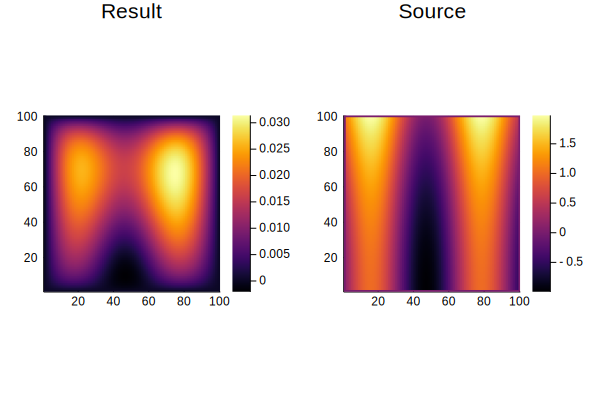

In [83]:
L = 1; H = 1; x_size = 100; y_size = 100
f,s = poisson_2d_dirichlet(nonlinear_s,homogeneous,L,H,(x_size,y_size))
#[linear_x(x,y,8,6) for x = 1:8, y=1:6]
p1 = heatmap(f,aspect_ratio=:equal,title="Result")
p2 = heatmap(s,aspect_ratio=:equal,title="Source")
plot(p1,p2,layout=2)